In [160]:
import warnings
warnings.filterwarnings("ignore")

In [161]:
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point

In [162]:
df_full = pd.read_csv("data/zomato_df_final_data.csv")

In [163]:
# haven't decided what to do with cuisine
# everyone has address, link, phone and title
# not sure why we have color and cuisine_color
# for regression 1 we wont use rating_text
# won't need lat and lng cause we will use subzone
df = df_full.drop(columns = ["address", "link", "phone", "title", "color", "cuisine_color", "rating_text", "lat", "lng"], axis = 1)

In [164]:
df.dtypes

cost             float64
cuisine           object
rating_number    float64
subzone           object
type              object
votes            float64
groupon             bool
cost_2           float64
dtype: object

In [165]:
# do some feature engineering
# change groupon bool to int
df.groupon = df.groupon.astype(int)

In [166]:
df.isna().sum()

cost              346
cuisine             0
rating_number    3316
subzone             0
type               48
votes            3316
groupon             0
cost_2            346
dtype: int64

# Using geopy Nominatim to check if I can get lat and lng values for an address from df["address"]

In [167]:
# # bringing address to see in helps
# df["address"] = df_full["address"]

# # check the addresses where lat is na
# temp = df[df.lat.isna()]
# temp.address

In [168]:
# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut

In [169]:
# i = 0
# for address in temp.address : 
#     print(f"{i}. address : {address}")
#     i += 1
#     try : 
#         geolocator = Nominatim(user_agent="address_to_ssc_code")
#         location = geolocator.geocode(address)
#         if location:
#             latitude, longitude = location.latitude, location.longitude
#             print(f"Latitude: {latitude}, Longitude: {longitude}")
#         else:
#             print("Address not found.")
#     except GeocoderTimedOut:
#         print("Geocoding service timed out. Address not found.")
#     except Exception as e:
#         print(f"An error occurred: Max retries exceeded")

# CHANGE OF PLAN
# timeout most of the time, checked until 59 found about 10 addresses

# Where lat is na, we can split address by "," and get the -1 of the resulting array

In [170]:
# missing_suburbs = temp.address.apply(lambda x : x.split(",")[-1].strip())
# missing_suburbs = [suburb.strip() for suburb in missing_suburbs]

In [171]:
# missing_suburbs.unique()

In [172]:
# df.loc[df['lat'].isna(), "address"] = df['address'].str.split(",").str[-1].str.strip()

# CHANGE OF PLAN
# Have about 52 uniqe missing_suburb from 192 rows
# which is good
# but most of them are sydney and cbd which are same
# does not get the actual subzone cause some of the addresses are like - 20 Campbell Street, Chinatown, Sydney
# got sydney instead of chinatown from the previous example
# Hopeless!

# If df["subzone"] has "," that means the subzone is not correct, we can split by "," and get the last part

In [173]:
# subzone is not suburb or at leats it's not correct for 1359 entries
# suburb name dont have comma
len(df[df.subzone.str.contains(",")])

1359

In [174]:
df['subzone'] = df['subzone'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else x)

In [175]:
len(df_full.subzone.unique())

572

In [176]:
len(df.subzone.unique())

339

In [177]:
df.isna().sum()

cost              346
cuisine             0
rating_number    3316
subzone             0
type               48
votes            3316
groupon             0
cost_2            346
dtype: int64

# Converting subzone to numeric value for the regression

In [178]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['subzone_encoded'] = label_encoder.fit_transform(df['subzone'])

# Will drop rows that has missing rating_number, if i do mediano or mean or mode, the model will be biased

In [179]:
df.dropna(subset=['rating_number'], inplace=True)

In [180]:
df.isna().sum()

cost               103
cuisine              0
rating_number        0
subzone              0
type                21
votes                0
groupon              0
cost_2             103
subzone_encoded      0
dtype: int64

# Replacing na in "cost" and "cost_2" with mean cost of the restaurants in that suburb

In [181]:
df['cost'] = df.groupby('subzone')['cost'].transform(lambda x: x.fillna(x.mean()))
df['cost_2'] = df.groupby('subzone')['cost_2'].transform(lambda x: x.fillna(x.mean()))
df = df.drop(columns = ["subzone"], axis = 1)

In [182]:
# just verifying
df.loc[793]

cost                            51.441718
cuisine            ['Chinese', 'Sichuan']
rating_number                         3.8
type                    ['Casual Dining']
votes                                40.0
groupon                                 0
cost_2                           5.355255
subzone_encoded                        69
Name: 793, dtype: object

# Dropping cuisine cause 135 one-hot-encoding is not reasonable, also rating is not so much related to cuisine

In [183]:
df = df.drop(columns = ["cuisine"])

In [184]:
df.isna().sum()

cost                0
rating_number       0
type               21
votes               0
groupon             0
cost_2              0
subzone_encoded     0
dtype: int64

# Fix up type and do one-hot-encoding

In [185]:
# filling na with most common type
most_frequent = df["type"].mode()[0]
df["type"].fillna(most_frequent, inplace=True)

In [186]:
import re
types = set()

#custom function to check all the values
def get_type(str):
    pattern = r',\s*' #removing comma(,) followed by immediate space
    cleaned_text = re.sub(pattern, '-', str)
    pattern2 = r'[\'\[\],]'
    cleaned_text = re.sub(pattern2, "", cleaned_text)
    temp = cleaned_text.split("-")
    for type in temp:
        types.add(type)

In [187]:
for value in df["type"]:
    get_type(value)
len(types)

# I HAD 14 TYPES BEFORE REMOVING RATING_NUMBER
# MISSING FOOD STALL

13

In [188]:
df_full.loc[df_full.rating_number.isna(), "type"].unique()

array(["['Casual Dining']", "['Café']", "['Bar', 'Fine Dining']",
       "['Fast Food']", "['Casual Dining', 'Bar']",
       "['Café', 'Casual Dining']", "['Dessert Parlour', 'Bakery']",
       "['Pub', 'Bar']", "['Casual Dining', 'Fast Food']",
       "['Fine Dining', 'Wine Bar']", "['Food Court']", "['Bar']",
       "['Casual Dining', 'Café']", "['Pub']", "['Fine Dining']",
       "['Dessert Parlour', 'Café']", "['Food Court', 'Café']",
       "['Bar', 'Casual Dining']", "['Bakery', 'Café']",
       "['Café', 'Bar']", "['Café', 'Dessert Parlour']",
       "['Fast Food', 'Food Court']", "['Café', 'Bakery']",
       "['Food Truck']", nan, "['Café', 'Wine Bar']",
       "['Club', 'Casual Dining']", "['Bakery']", "['Beverage Shop']",
       "['Fine Dining', 'Bar']", "['Café', 'Food Court']",
       "['Dessert Parlour']", "['Casual Dining', 'Food Stall']",
       "['Wine Bar']", "['Club']", "['Bar', 'Club']",
       "['Food Court', 'Casual Dining']", "['Pub', 'Casual Dining']",
       "['

In [189]:
df.type.unique()

array(["['Casual Dining']", "['Café']", "['Fine Dining']",
       "['Fine Dining', 'Bar']", "['Casual Dining', 'Dessert Parlour']",
       "['Fine Dining', 'Wine Bar']", "['Casual Dining', 'Wine Bar']",
       "['Casual Dining', 'Bar']", "['Fast Food']", "['Café', 'Bakery']",
       "['Casual Dining', 'Café']", "['Bar']",
       "['Bakery', 'Dessert Parlour']", "['Bar', 'Wine Bar']",
       "['Food Court']", "['Dessert Parlour', 'Café']",
       "['Bar', 'Casual Dining']", "['Bakery', 'Pub']",
       "['Café', 'Casual Dining']", "['Café', 'Bar']",
       "['Casual Dining', 'Pub']", "['Bakery', 'Café']", "['Food Truck']",
       "['Café', 'Dessert Parlour']", "['Dessert Parlour']", "['Pub']",
       "['Pub', 'Casual Dining']", "['Dessert Parlour', 'Bakery']",
       "['Café', 'Wine Bar']", "['Pub', 'Wine Bar']",
       "['Food Court', 'Casual Dining']", "['Wine Bar', 'Casual Dining']",
       "['Casual Dining', 'Food Court']", "['Club', 'Bar']",
       "['Casual Dining', 'Bakery']", "['

In [190]:
types

{'Bakery',
 'Bar',
 'Beverage Shop',
 'Café',
 'Casual Dining',
 'Club',
 'Dessert Parlour',
 'Fast Food',
 'Fine Dining',
 'Food Court',
 'Food Truck',
 'Pub',
 'Wine Bar'}

In [191]:
# one hot encoding
for dining_type in types:
    df[f"is_{dining_type}"] = df['type'].apply(lambda x: 1 if dining_type in x else 0)
df.drop('type', axis=1, inplace=True)

# Regression model 1

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# X,y
X = df.drop(columns=['rating_number'])  # Features
y = df['rating_number']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_regression_1 = LinearRegression()
model_regression_1.fit(X_train, y_train)

# predictions
y_pred = model_regression_1.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.14698460727663623
R-squared: 0.2539981092695366


# Regression model 2, will need to apply standardization for gradient descent

In [193]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_regression_2 = SGDRegressor(loss="squared_error", max_iter=1000, random_state=0)
model_regression_2.fit(X_train_scaled, y_train)

y_pred = model_regression_2.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.14910993202209347
R-squared: 0.24321129078626968


# Classification

In [194]:
df_full.dropna(subset=["rating_text"], inplace=True)
df["rating_text"] = df_full["rating_text"]

In [195]:
class_mapping = {
    "Poor": 1,
    "Average": 1,
    "Good": 2,
    "Very Good": 2,
    "Excellent": 2
}
df["binary_rating"] = df["rating_text"].map(class_mapping)
df = df.drop(columns = ["rating_text"], axis = 1)

In [196]:
# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [197]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


X = df.drop(columns=['binary_rating'])  # Features
y = df['binary_rating']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

classification_model_logistic_regression_3 = LogisticRegression()
classification_model_logistic_regression_3.fit(X_train, y_train)

# predictions
y_pred = classification_model_logistic_regression_3.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9784272790535838
Precision: 0.9770354906054279
Recall: 0.9904761904761905
F1 Score: 0.9837099316868103
ROC AUC Score: 0.9728803716608595
Confusion Matrix:
 [[936   9]
 [ 22 470]]


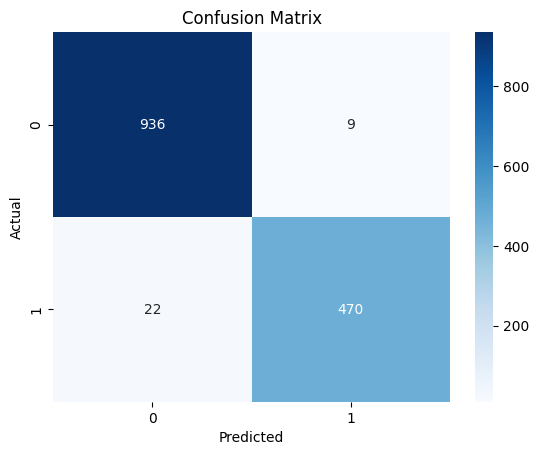

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Conclusion

Out of 945 values 0 ratings, the logistic regression model classified 936 correctly and 9 incorrectly.
On the other hand, from 492 total 1 ratings, the model predicted 22 incorrectly and 470 correctly.
Overall accuracy is 97%, the model predicted 99% of all true positive values suggested by the recall and area under ROC curver is 97%.  
So we can conclude that the model "classification_model_logistic_regression_3" is performing well.

# Bonus

In [200]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Already have X_train, X_test, y_train and y_test

# models
# SVM with linear kernel
# SVM with radial bias function kerner
# decision tree model
# random forest model
models = {
    'Linear SVM': SVC(kernel='linear', random_state=0),
    'RBF SVM': SVC(kernel='rbf', random_state=0),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0)
}

# eval dictionary
evaluation_metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    evaluation_metrics['Model'].append(model_name)
    evaluation_metrics['Accuracy'].append(accuracy)
    evaluation_metrics['Precision'].append(precision)
    evaluation_metrics['Recall'].append(recall)
    evaluation_metrics['F1 Score'].append(f1)
    evaluation_metrics['ROC AUC'].append(roc_auc)

classification_accuracy_eval = pd.DataFrame(evaluation_metrics)

classification_accuracy_eval


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Linear SVM,1.000000,0.977035,0.990476,0.98371,0.97288
1,RBF SVM,0.856646,0.977035,0.990476,0.98371,0.97288
2,Decision Tree,1.000000,0.977035,0.990476,0.98371,0.97288
3,Random Forest,1.000000,0.977035,0.990476,0.98371,0.97288
